### Deep Convolutional Generative Adversarial Network
view https://arxiv.org/abs/1511.06434

In [179]:
import torch
from torch import nn
import torchvision.datasets
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [253]:
batch_size = 16
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [181]:
transform = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST('./MNIST_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
mnist_test = torchvision.datasets.MNIST('./MNIST_data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

In [198]:
class Flatten(nn.Module):
    def forward(self, input):
        flattened = input.view(input.shape[0], -1)
        return flattened

In [212]:
class Unflatten(nn.Module):
    def __init__(self, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, input):
        unflattened = input.view(-1, self.C, self.H, self.W)
        return unflattened

In [213]:
def generate_nosie(batch_size, dim=96):
    noise = torch.rand(batch_size, dim) * 2 - 1
    return noise

In [284]:
def CNN():
    model = nn.Sequential(
        nn.Conv2d(1, 32, [5,5], stride=[1,1]),
        nn.LeakyReLU(negative_slope=.01),
        nn.MaxPool2d([2,2], stride=[2,2]),
        nn.Conv2d(32, 64, [5,5], stride=[1,1]),
        nn.LeakyReLU(negative_slope=.01),
        nn.MaxPool2d([2,2], stride=[2,2]),
        Flatten(),
        nn.Linear((4*4*64), (4*4*64)), 
        nn.LeakyReLU(negative_slope=.01),
        nn.Linear((4*4*64), 1)
    )
    return model

In [285]:
def generator(noise_dim=96):
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, (7*7*128)),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128),
        Unflatten(),
        nn.ConvTranspose2d(128, 64, [4,4], stride=[2,2], padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, [4,4], stride=[2,2], padding=1),
        nn.Tanh(),
        Flatten()
    )
    return model

In [286]:
def create_optimizer(model, lr=.01, betas=None):
    if betas == None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    return optimizer

In [287]:
def discriminator_loss(scores_real, scores_fake):
    true_labels = torch.ones_like(scores_real)
    valid_loss = torch.mean((scores_real - true_labels) ** 2) * .5
    invalid_loss = torch.mean(scores_fake ** 2) * .5
    loss = valid_loss + invalid_loss
    return loss

In [288]:
def generator_loss(scores_fake):
    true_labels = torch.ones_like(scores_fake)
    loss = torch.mean((scores_fake - true_labels) ** 2) * .5
    return loss

In [289]:
def show_image(images):
#     for image in images:
    images_np = images.detach().numpy().squeeze()
#     side_length = np.sqrt(images.shape[1])
#     print("side length", side_length, images.shape)
#     assert(side_length % 1 == 0), "images not square shape"
#     image_show = images[0]
#     image_unflattened = np.reshape(image_show, (int(side_length), int(side_length)))
#     plt.imshow(image_unflattened)
    plt.imshow(images_np[0])
    plt.show()

In [290]:
def train_gan(generator, discriminator, image_loader, epochs, num_train_batches=-1):
    generator_optimizer = create_optimizer(generator, lr=1e-3, betas=(.5, .999))
    discriminator_optimizer = create_optimizer(discriminator, lr=1e-3, betas=(.5, .999))
    iters = 0
    for epoch in range(epochs):
        for i, (examples, labels) in enumerate(image_loader):
            if i == num_train_batches:
                break
            generator_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            z = generate_nosie(batch_size)
            images_fake = generator(z)
            images_fake_unflattened = images_fake.view(images_fake.shape[0], 1, 28, 28)
            scores_fake = discriminator(images_fake_unflattened)
            
            ##TODO, fix scores_fake 10 class problem
            
            g_cost = generator_loss(scores_fake)
            g_cost.backward(retain_graph=True)
            generator_optimizer.step()

            scores_real = discriminator(examples)
            d_cost = discriminator_loss(scores_real, scores_fake)
            d_cost.backward()
            discriminator_optimizer.step()
            iters += 1
            if iters % 100  == 0:
                print("Iteration:", iters)
                print("Discriminator Cost", d_cost)
                print("Generator Cost", g_cost)
                show_image(images_fake_unflattened)
                

    return generator, discriminator

In [291]:
generator = generator()
discriminator = CNN()
image_loader = train_loader
epochs = 5
num_train_batches = 1000

Iteration: 100
Discriminator Cost tensor(0.2075)
Generator Cost tensor(1.00000e-02 *
       7.4122)


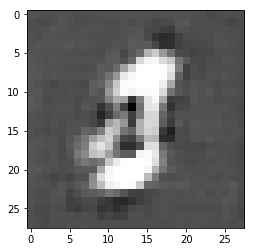

Iteration: 200
Discriminator Cost tensor(0.2086)
Generator Cost tensor(1.00000e-02 *
       7.0926)


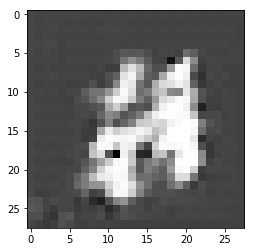

Iteration: 300
Discriminator Cost tensor(0.1497)
Generator Cost tensor(0.1265)


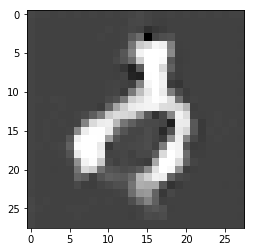

Iteration: 400
Discriminator Cost tensor(0.1650)
Generator Cost tensor(0.1023)


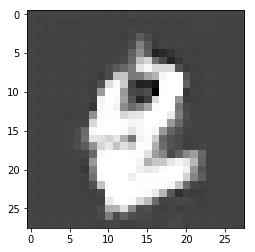

Iteration: 500
Discriminator Cost tensor(0.1402)
Generator Cost tensor(0.1463)


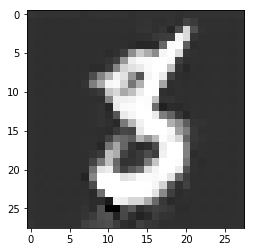

Iteration: 600
Discriminator Cost tensor(0.1321)
Generator Cost tensor(0.1704)


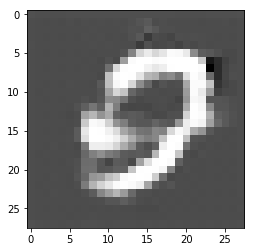

Iteration: 700
Discriminator Cost tensor(0.1828)
Generator Cost tensor(1.00000e-02 *
       9.4029)


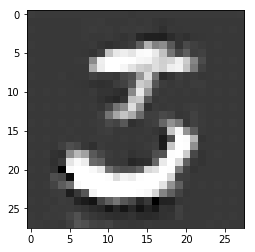

Iteration: 800
Discriminator Cost tensor(0.1046)
Generator Cost tensor(0.1581)


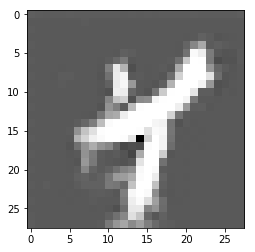

Iteration: 900
Discriminator Cost tensor(0.1678)
Generator Cost tensor(1.00000e-02 *
       9.7878)


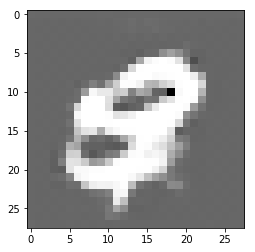

Iteration: 1000
Discriminator Cost tensor(0.1340)
Generator Cost tensor(0.1370)


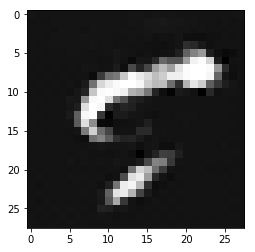

Iteration: 1100
Discriminator Cost tensor(0.1531)
Generator Cost tensor(0.1065)


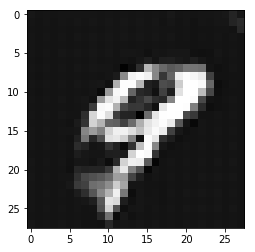

Iteration: 1200
Discriminator Cost tensor(0.1252)
Generator Cost tensor(0.1339)


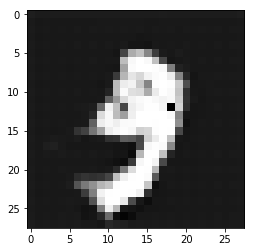

Iteration: 1300
Discriminator Cost tensor(0.1436)
Generator Cost tensor(0.1183)


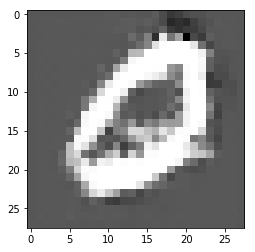

Iteration: 1400
Discriminator Cost tensor(0.1462)
Generator Cost tensor(0.1076)


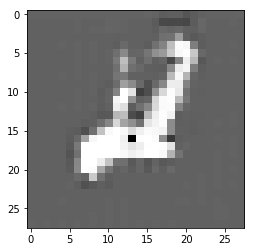

Iteration: 1500
Discriminator Cost tensor(0.1262)
Generator Cost tensor(0.1290)


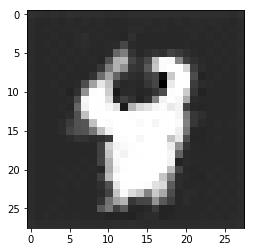

Iteration: 1600
Discriminator Cost tensor(0.1267)
Generator Cost tensor(0.1265)


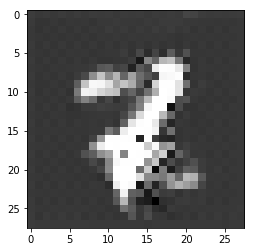

Iteration: 1700
Discriminator Cost tensor(0.1322)
Generator Cost tensor(0.1204)


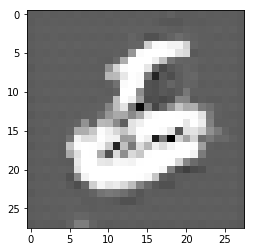

Iteration: 1800
Discriminator Cost tensor(0.1117)
Generator Cost tensor(0.1454)


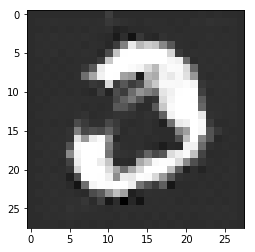

Iteration: 1900
Discriminator Cost tensor(0.1337)
Generator Cost tensor(0.1184)


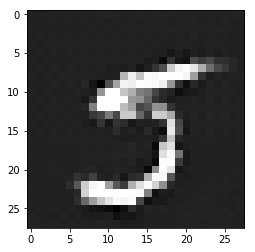

Iteration: 2000
Discriminator Cost tensor(0.1353)
Generator Cost tensor(0.1168)


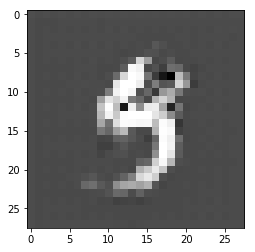

Iteration: 2100
Discriminator Cost tensor(0.1288)
Generator Cost tensor(0.1221)


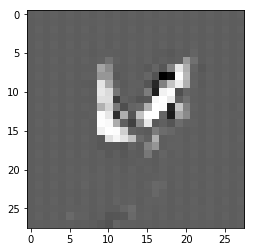

Iteration: 2200
Discriminator Cost tensor(0.1256)
Generator Cost tensor(0.1249)


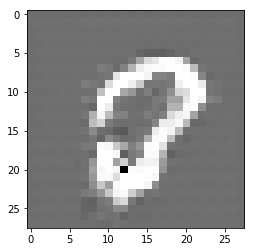

Iteration: 2300
Discriminator Cost tensor(0.1234)
Generator Cost tensor(0.1271)


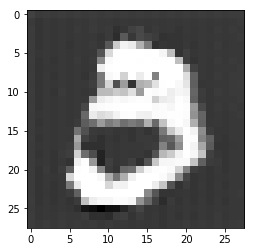

Iteration: 2400
Discriminator Cost tensor(0.1206)
Generator Cost tensor(0.1313)


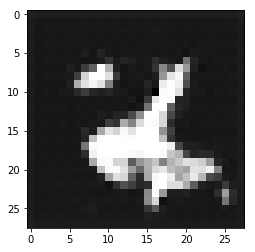

Iteration: 2500
Discriminator Cost tensor(0.1302)
Generator Cost tensor(0.1213)


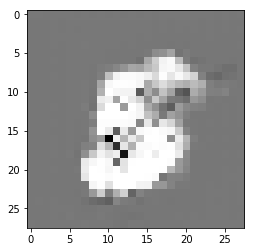

Iteration: 2600
Discriminator Cost tensor(0.1353)
Generator Cost tensor(0.1178)


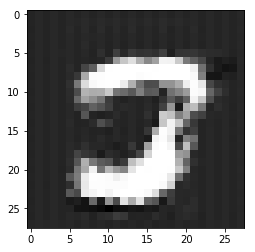

Iteration: 2700
Discriminator Cost tensor(0.1206)
Generator Cost tensor(0.1301)


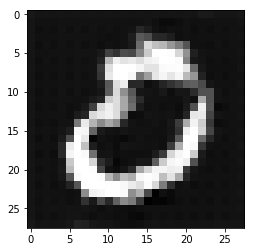

Iteration: 2800
Discriminator Cost tensor(0.1216)
Generator Cost tensor(0.1302)


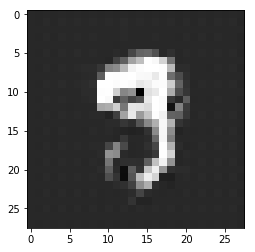

Iteration: 2900
Discriminator Cost tensor(0.1253)
Generator Cost tensor(0.1253)


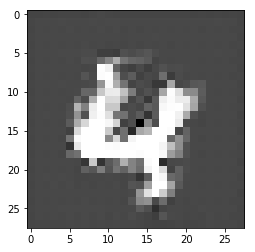

Iteration: 3000
Discriminator Cost tensor(0.1384)
Generator Cost tensor(0.1145)


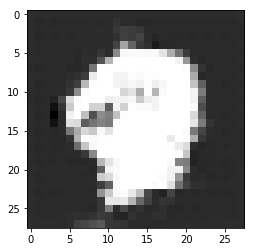

Iteration: 3100
Discriminator Cost tensor(0.1264)
Generator Cost tensor(0.1241)


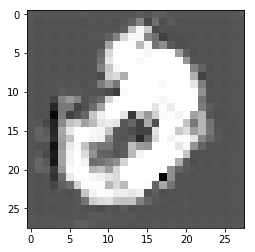

Iteration: 3200
Discriminator Cost tensor(0.1270)
Generator Cost tensor(0.1232)


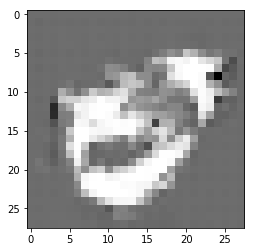

Iteration: 3300
Discriminator Cost tensor(0.1266)
Generator Cost tensor(0.1239)


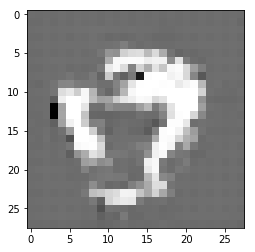

Iteration: 3400
Discriminator Cost tensor(0.1247)
Generator Cost tensor(0.1255)


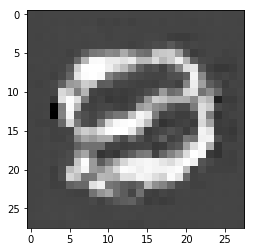

Iteration: 3500
Discriminator Cost tensor(0.1271)
Generator Cost tensor(0.1234)


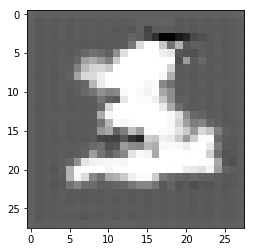

Iteration: 3600
Discriminator Cost tensor(0.1259)
Generator Cost tensor(0.1244)


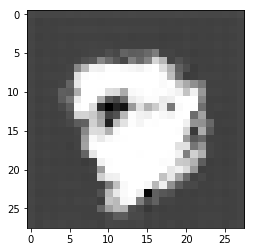

Iteration: 3700
Discriminator Cost tensor(0.1252)
Generator Cost tensor(0.1250)


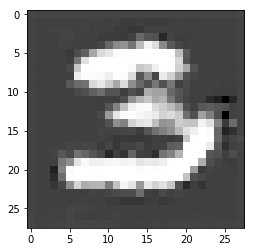

Iteration: 3800
Discriminator Cost tensor(0.1248)
Generator Cost tensor(0.1253)


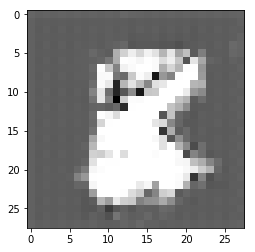

Iteration: 3900
Discriminator Cost tensor(0.1249)
Generator Cost tensor(0.1252)


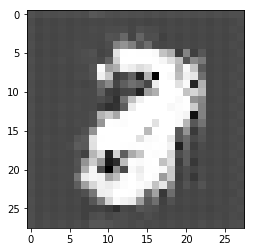

Iteration: 4000
Discriminator Cost tensor(0.1257)
Generator Cost tensor(0.1245)


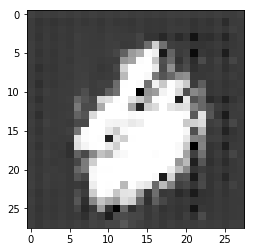

Iteration: 4100
Discriminator Cost tensor(0.1292)
Generator Cost tensor(0.1217)


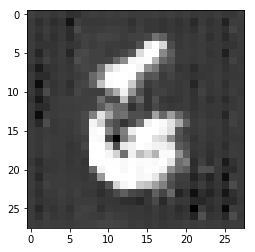

Iteration: 4200
Discriminator Cost tensor(0.1259)
Generator Cost tensor(0.1242)


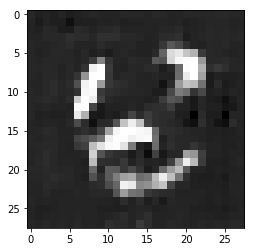

Iteration: 4300
Discriminator Cost tensor(0.1271)
Generator Cost tensor(0.1234)


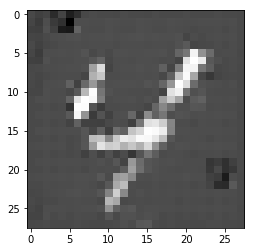

Iteration: 4400
Discriminator Cost tensor(0.1245)
Generator Cost tensor(0.1256)


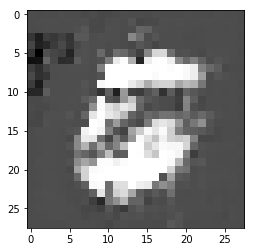

Iteration: 4500
Discriminator Cost tensor(0.1272)
Generator Cost tensor(0.1244)


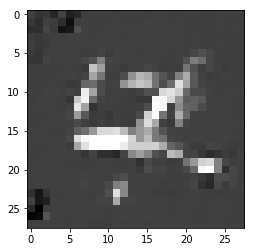

Iteration: 4600
Discriminator Cost tensor(0.3890)
Generator Cost tensor(1.00000e-02 *
       4.3429)


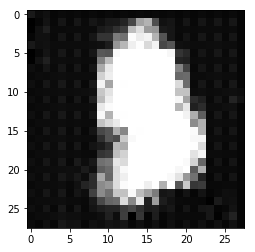

Iteration: 4700
Discriminator Cost tensor(0.1362)
Generator Cost tensor(0.1172)


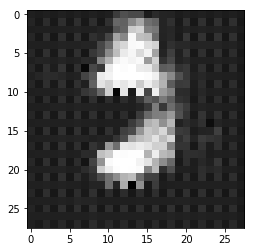

Iteration: 4800
Discriminator Cost tensor(0.1891)
Generator Cost tensor(1.00000e-02 *
       8.3950)


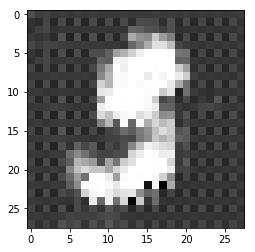

Iteration: 4900
Discriminator Cost tensor(0.1474)
Generator Cost tensor(0.1097)


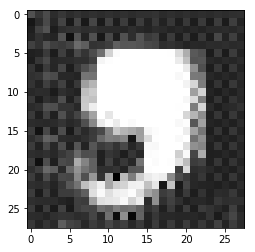

Iteration: 5000
Discriminator Cost tensor(0.1738)
Generator Cost tensor(1.00000e-02 *
       9.3330)


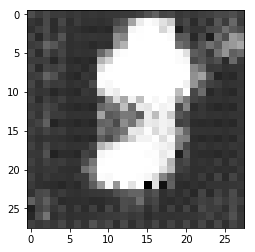

(Sequential(
   (0): Linear(in_features=96, out_features=1024, bias=True)
   (1): ReLU()
   (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Linear(in_features=1024, out_features=6272, bias=True)
   (4): ReLU()
   (5): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Unflatten()
   (7): ConvTranspose2d(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=(1, 1))
   (8): ReLU()
   (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ConvTranspose2d(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=(1, 1))
   (11): Tanh()
   (12): Flatten()
 ), Sequential(
   (0): Conv2d(1, 32, kernel_size=[5, 5], stride=[1, 1])
   (1): LeakyReLU(negative_slope=0.01)
   (2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(32, 64, kernel_size=[5, 5], stride=[1, 1])
   (4): LeakyReLU(negative_slope=0.01)
   (5): MaxPool2d(kernel_s

In [292]:
train_gan(generator, discriminator, image_loader, epochs, num_train_batches=num_train_batches)